In [1]:
import pandas as pd
df = pd.read_csv("~/desktop/apartment_crawler/top_20_data.csv")

In [ ]:
from geopy.geocoders import Nominatim
from tqdm.auto import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import geopy.geocoders
geopy.geocoders.options.default_timeout = 10

geolocator = Nominatim(user_agent="petfees")
df['address_cleaned'] = df['address'].str.split('–').apply(lambda x: x[0])
df['geopy'] = df['address_cleaned'].progress_apply(lambda address: geolocator.geocode(address, addressdetails=True)) # Can take ~50min
df['longitude'] = df['geopy'].parallel_apply(lambda geopy_address: geopy_address.longitude if geopy_address else None)
df['latitude'] = df['geopy'].parallel_apply(lambda geopy_address: geopy_address.latitude if geopy_address else None)

In [ ]:
df['spatialjusticetemplate'] = df.parallel_apply(lambda row: "http://www.spatialjusticetest.org/api.php?fLat={}&fLon={}&sGeo=tract".format(row['latitude'], row['longitude']), axis=1)

In [9]:
import requests
import json
def get_census_data(row):
    content = ""
    try:
        content = requests.get(row['spatialjusticetemplate']).content
        return json.loads(content.decode("utf-8"))
    except:
        return content
df['census'] = df.parallel_apply(get_census_data, axis=1)

In [11]:
# import pickle as pkl
# with open("geo.pkl", "wb") as fp:
#     pkl.dump(df, fp)

In [1]:
import pickle as pkl
with open("geo.pkl", "rb") as fp:
    df = pkl.load(fp)

In [3]:
import pandas as pd
df['geopy_raw'] = df['geopy'].apply(lambda x: x.raw if x != None else None)
explode_dict_column = lambda _df, col: pd.concat([_df.drop([col], axis=1), _df[col].apply(lambda x: pd.Series(x) if x != None else pd.Series()).add_suffix("_"+col)], axis=1)
df = explode_dict_column(df, "geopy_raw")
df = explode_dict_column(df, 'address_geopy_raw')
tmp = explode_dict_column(df, 'census')

<ipython-input-3-e8024b3b6ade>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  explode_dict_column = lambda _df, col: pd.concat([_df.drop([col], axis=1), _df[col].apply(lambda x: pd.Series(x) if x != None else pd.Series()).add_suffix("_"+col)], axis=1)


In [5]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt

In [6]:
shp_path = "cb_2018_48_tract_500k.shp"
sf = shp.Reader(shp_path)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]
df = pd.DataFrame(columns=fields, data=records)
df = df.assign(coords=shps)

fips = pd.read_html("https://www.dshs.texas.gov/chs/info/info_txco.shtm#:~:text=The%20county%20FIPS%20(Federal%20Information,county_number%20*%202)%20%2D%201.", header=0)[0]

def get_county_fips(county):
    try:
        return str(list(fips[fips['CountyName'].str.contains(str(county).replace(" County", ""))]['FIPSCode'])[0])
    except:
        return None
tmp['fips'] = tmp['county_address_geopy_raw'].apply(get_county_fips)

tmp['state_fips_code'] = tmp['fips'].apply(lambda x: x[:2] if x else None)
tmp['county_fips_code'] = tmp['fips'].apply(lambda x: x[2:] if x else None)
tmp['fips_agg'] = tmp.apply(lambda row: str(row['state_fips_code']) + str(row['county_fips_code']) + str(row['name10_census']), axis=1).astype(str)
df['fips_agg'] = df.apply(lambda row: row['STATEFP'] + row['COUNTYFP'] + row['NAME'], axis=1).astype(str)

final = tmp.merge(df, how="left", on="fips_agg")

In [78]:
list(final.columns)

['Unnamed: 0',
 'index',
 'name',
 'address',
 'rating',
 'reviews',
 'price_ranges',
 '1 BR SQFT',
 '2 BR SQFT',
 '3 BR SQFT',
 '4 BR SQFT',
 '5 BR SQFT',
 'Assigned Covered Parking Recurring',
 'Cat Rent Recurring',
 'Dog Rent Recurring',
 'Unassigned Covered Parking Recurring',
 'Assigned Garage Parking Recurring',
 'Unassigned Garage Parking Recurring',
 'Admin Fee OneTime',
 'Application Fee OneTime',
 'Cat Fee OneTime',
 'Dog Fee OneTime',
 'Cat Deposit OneTime',
 'Dog Deposit OneTime',
 'Storage Fee Recurring',
 'Other Rent Recurring',
 'Assigned Surface Lot Parking Recurring',
 'Assigned Other Parking Recurring',
 'Unassigned Other Parking Recurring',
 'Unassigned Surface Lot Parking Recurring',
 'Reptile Deposit OneTime',
 'Other Fee(s) OneTime',
 'Other Deposit(s) OneTime',
 'Bird Deposit OneTime',
 'Fish Deposit OneTime',
 'Bird Rent Recurring',
 'Fish Rent Recurring',
 'Assigned Street Parking Recurring',
 'Reptile Rent Recurring',
 'Bird Fee OneTime',
 'Fish Fee OneTime',


In [127]:
final['pop_census_cleaned'] = final['pop_census'].fillna(0).astype(int)
normalize = lambda l: (np.array(l)-min(l))/(max(l)-min(l))
final['pop_census_cleaned_normed'] = normalize(final['pop_census_cleaned'])

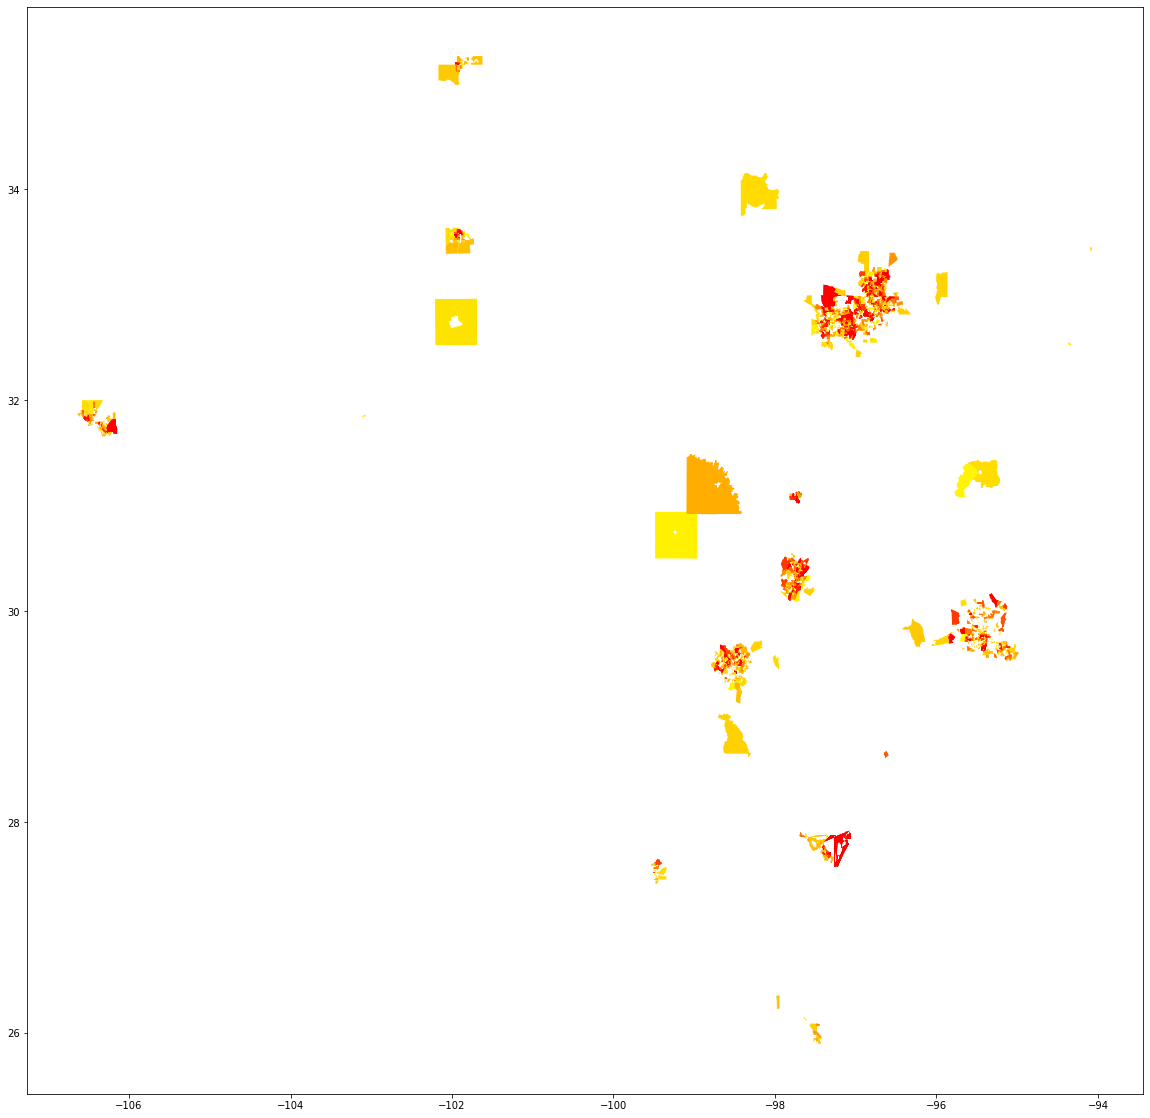

In [129]:
from matplotlib.colors import to_hex

cmap = plt.cm.autumn_r

plt.figure(figsize=(20, 20))

for grp, vals in final.groupby(['COUNTYFP', 'NAME']):
    pop = sum(vals['pop_census_cleaned_normed'])
    coord = list(vals['coords'])
    plt.fill(*np.transpose(coord), to_hex(cmap(pop)), edgecolor=None, linewidth=0)

In [130]:
final.to_csv("full_data.csv")

In [182]:
import ast
rent = [
 'Cat Rent Recurring',
 'Dog Rent Recurring',
 'Bird Rent Recurring',
 'Fish Rent Recurring',
 'Reptile Rent Recurring',
]

fees = [
 'Cat Fee OneTime',
 'Dog Fee OneTime',
 'Bird Fee OneTime',
 'Fish Fee OneTime',
 'Reptile Fee OneTime',
]

deposits = [
 'Cat Deposit OneTime',
 'Dog Deposit OneTime',
 'Reptile Deposit OneTime',
 'Bird Deposit OneTime',
 'Fish Deposit OneTime']

final['max_rent'] = final[rent].applymap(lambda x: (0, 0) if str(x) == 'nan' else ast.literal_eval(x)).applymap(lambda x: x[1]).max(axis=1)
final['max_fee'] = final[fees].applymap(lambda x: (0, 0) if str(x) == 'nan' else ast.literal_eval(x)).applymap(lambda x: x[1]).max(axis=1)
final['max_deposit'] = final[deposits].applymap(lambda x: (0, 0) if str(x) == 'nan' else ast.literal_eval(x)).applymap(lambda x: x[1]).max(axis=1)
final['max_cost_single_animal'] = final['max_rent']*12 + final['max_fee'] + final['max_deposit']
final['max_cost_single_animal_normed'] = normalize(final['max_cost_single_animal'])

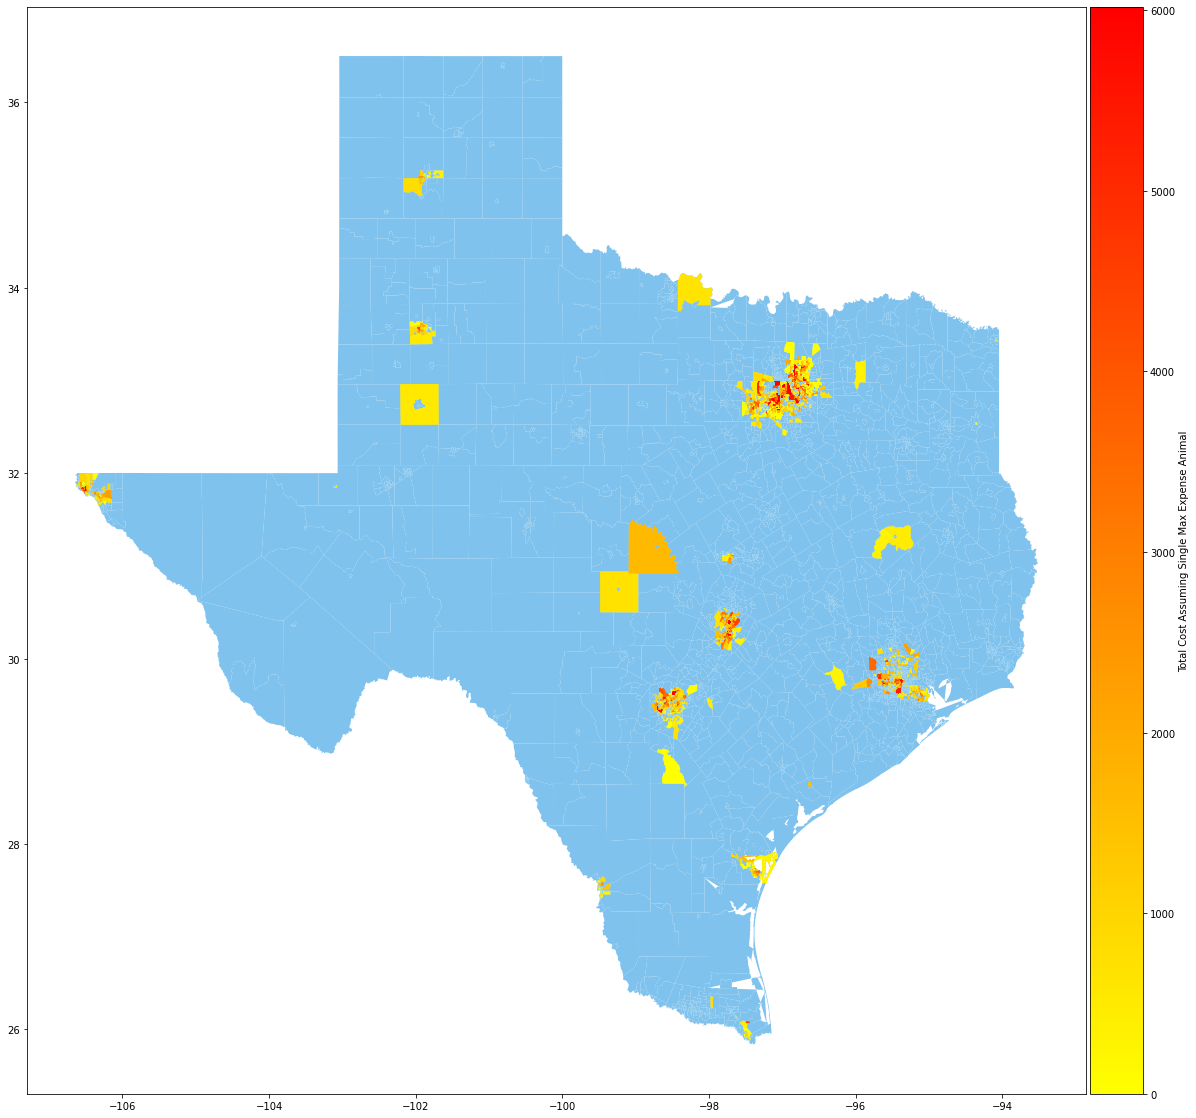

In [194]:
from matplotlib.colors import to_hex
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = plt.cm.autumn_r

fig = plt.figure(figsize=(20, 20))
cs = []

for coord in df['coords']:
     plt.fill(*np.transpose(coord), c="#7ec2ed", edgecolor=None, linewidth=0)

for grp, vals in final.groupby(['COUNTYFP', 'NAME']):
    c = sum(vals['max_cost_single_animal_normed'])
    cs.append(c)
    coord = list(vals['coords'])
    plt.fill(*np.transpose(coord), to_hex(cmap(c)), edgecolor=None, linewidth=0)
    
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
norm = mpl.colors.Normalize(vmin=min(final['max_cost_single_animal']), vmax=max(final['max_cost_single_animal']))
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Total Cost Assuming Single Max Expense Animal')

In [235]:
final['income_census_cleaned'] = pd.to_numeric(final['income_census'], errors="coerce").fillna(0).astype(float)
final['white_census_cleaned'] = pd.to_numeric(final['white_census'], errors="coerce").fillna(0).astype(float)
final['cost_ratio'] = final['max_cost_single_animal'] / final['income_census_cleaned']
final = final.replace([np.inf, -np.inf], np.nan).fillna(0)

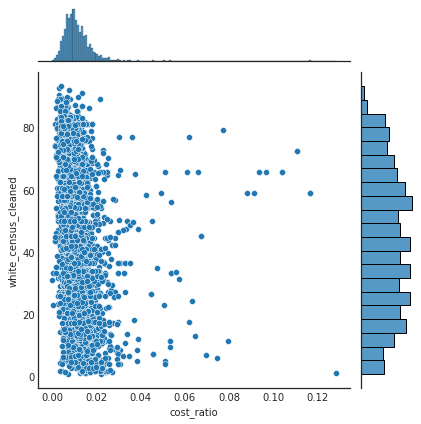

In [240]:
import seaborn as sns
sns.jointplot(data=final[[a != 0 and b != 0 for a, b in zip(final['cost_ratio'], final['white_census_cleaned'])]], x="cost_ratio", y="white_census_cleaned")